In [2]:
# 命令式编程
def add(a, b):
    return a + b

def fancy_func(a, b, c, d):
    e = add(a, b)
    f = add(c, d)
    g = add(e, f)
    return g

print(fancy_func(1, 2, 3, 4))

10


In [3]:
# 符号式编程：即代码通常只在完全定义了过程之后才执行计算
# 1. 定义计算流程
# 2. 将流程编译成可执行的程序
# 3. 给定输入, 调用编译好的程序执行

In [4]:
def add_():
    return '''
def add(a, b):
    return a + b
'''

def fancy_func_():
    return '''
def fancy_func(a, b, c, d):
    e = add(a, b)
    f = add(c, d)
    g = add(e, f)
    return g
'''

def evoke_():
    return add_() + fancy_func_() + 'print(fancy_func(1, 2, 3, 4))'

prog = evoke_()
print(prog)
y = compile(prog, '', 'exec')
exec(y)


def add(a, b):
    return a + b

def fancy_func(a, b, c, d):
    e = add(a, b)
    f = add(c, d)
    g = add(e, f)
    return g
print(fancy_func(1, 2, 3, 4))
10


命令式（解释型）编程和符号式编程的区别如下：

命令式编程更容易使用。在Python中，命令式编程的大部分代码都是简单易懂的。命令式编程也更容易调试，这是因为无论是获取和打印所有的中间变量值，或者使用Python的内置调试工具都更加简单；

符号式编程运行效率更高，更易于移植。符号式编程更容易在编译期间优化代码，同时还能够将程序移植到与Python无关的格式中，从而允许程序在非Python环境中运行，避免了任何潜在的与Python解释器相关的性能问题。

PyTorch是基于命令式编程并且使用动态计算图。为了能够利用符号式编程的可移植性和效率，开发人员思考能否将这两种编程模型的优点结合起来，于是就产生了torchscript。torchscript允许用户使用纯命令式编程进行开发和调试，同时能够将大多数程序转换为符号式程序，以便在需要产品级计算性能和部署时使用。

In [5]:
import torch
from torch import nn
from d2l import torch as d2l


# 生产网络的工厂模式
def get_net():
    net = nn.Sequential(nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 2))
    return net

x = torch.randn(size=(1, 512))
net = get_net()
net(x)

tensor([[-0.0189,  0.1361]], grad_fn=<AddmmBackward0>)

In [6]:
# 使用torch.jit.script函数来转换模型，我们就有能力编译和优化多层感知机中计算
# 而模型的计算结果保持不变
net = torch.jit.script(net)
net(x)

tensor([[-0.0189,  0.1361]], grad_fn=<AddmmBackward0>)

编写与之前相同的代码，再使用torch.jit.script简单地转换模型，当完成这些任务后，网络就将得到优化（我们将在下面对性能进行基准测试）。

In [7]:
#@save
class Benchmark:
    """用于测量运行时间"""
    def __init__(self, description='Done'):
        self.description = description

    def __enter__(self):
        self.timer = d2l.Timer()
        return self

    def __exit__(self, *args):
        print(f'{self.description}: {self.timer.stop():.4f} sec')

In [11]:
net = get_net()
with Benchmark('无torchscript'):
    for i in range(1000): net(x)

net = torch.jit.script(net)
with Benchmark('有torchscript'):
    for i in range(1000): net(x)

无torchscript: 0.2046 sec
有torchscript: 0.1670 sec


编译模型的好处之一是我们可以将模型及其参数序列化（保存）到磁盘。这允许这些训练好的模型部署到其他设备上，并且还能方便地使用其他前端编程语言。同时，通常编译模型的代码执行速度也比命令式编程更快。让我们看看save的实际功能。

In [13]:
# net.save("my_mlp")

异步计算

MXNet和TensorFlow之类则采用了一种异步编程（asynchronous programming）模型来提高性能，而PyTorch则使用了Python自己的调度器来实现不同的性能权衡。

对PyTorch来说GPU操作在默认情况下是异步的。当调用一个使用GPU的函数时，操作会排队到特定的设备上，但不一定要等到以后才执行。这允许我们并行执行更多的计算，包括在CPU或其他GPU上的操作。

In [15]:
import os
import subprocess
import numpy
import torch
from torch import nn
from d2l import torch as d2l

In [16]:
# GPU计算热身
device = d2l.try_gpu()
a = torch.randn(size=(1000, 1000), device=device)
b = torch.mm(a, a)

with d2l.Benchmark('numpy'):
    for _ in range(10):
        a = numpy.random.normal(size=(1000, 1000))
        b = numpy.dot(a, a)

with d2l.Benchmark('torch'):
    for _ in range(10):
        a = torch.randn(size=(1000, 1000), device=device)
        b = torch.mm(a, a)

numpy: 0.5076 sec
torch: 0.0030 sec


In [17]:
with d2l.Benchmark():
    for _ in range(10):
        a = torch.randn(size=(1000, 1000), device=device)
        b = torch.mm(a, a)
    torch.cuda.synchronize(device)

Done: 0.1141 sec


In [18]:
x = torch.ones((1, 2), device=device)
y = torch.ones((1, 2), device=device)
z = x * y + 2
z

tensor([[3., 3.]], device='cuda:0')

深度学习框架可以将Python前端的控制与后端的执行解耦，使得命令可以快速地异步插入后端、并行执行。

In [20]:
devices = d2l.try_all_gpus()
def run(x):
    return [x.mm(x) for _ in range(50)]

x_gpu1 = torch.rand(size=(4000, 4000), device=devices[0])
x_gpu2 = torch.rand(size=(4000, 4000), device=devices[0])

### 没有两个GPU
run(x_gpu1)
run(x_gpu2)  # 预热设备
torch.cuda.synchronize(devices[0])
torch.cuda.synchronize(devices[1])

with d2l.Benchmark('GPU1 time'):
    run(x_gpu1)
    torch.cuda.synchronize(devices[0])

with d2l.Benchmark('GPU2 time'):
    run(x_gpu2)
    torch.cuda.synchronize(devices[1])
    
with d2l.Benchmark('GPU1 & GPU2'):
    run(x_gpu1)
    run(x_gpu2)
    torch.cuda.synchronize()  

In [22]:
def copy_to_cpu(x, non_blocking=False):
    return [y.to('cpu', non_blocking=non_blocking) for y in x]

with d2l.Benchmark('在GPU1上运行'):
    y = run(x_gpu1)
    torch.cuda.synchronize()

with d2l.Benchmark('复制到CPU'):
    y_cpu = copy_to_cpu(y)
    torch.cuda.synchronize()

在GPU1上运行: 2.8010 sec
复制到CPU: 2.4420 sec


In [23]:
with d2l.Benchmark('在GPU1上运行并复制到CPU'):
    y = run(x_gpu1)
    y_cpu = copy_to_cpu(y, True)
    torch.cuda.synchronize()

在GPU1上运行并复制到CPU: 4.7989 sec


### 多GPU训练
1. 在多个GPU之间拆分网络
2. 拆分层内的工作
3. 跨多个GPU对数据进行拆分，但是添加更多的GPU并不能让我门训练更大的模型

K个GPU并行训练过程如下：
1. 在任何一次训练迭代中，给定的随机小批量样本都将被分成K份，并均匀的分配到GPU上
2. 每个GPU根据分配给它的小批量子集，计算模型参数的损失和梯度
3. 将K个GPU中的局部梯度聚合，以获得当前小批量的随机梯度
4. 聚合梯度被重新分发到每个GPU
5. 每个GPU使用这个小批量随机梯度，来更新它所维护的完整的模型参数集

In [24]:
%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [25]:
# 初始化模型参数
scale = 0.01
W1 = torch.randn(size=(20, 1, 3, 3)) * scale
b1 = torch.zeros(20)
W2 = torch.randn(size=(50, 20, 5, 5)) * scale
b2 = torch.zeros(50)
W3 = torch.randn(size=(800, 128)) * scale
b3 = torch.zeros(128)
W4 = torch.randn(size=(128, 10)) * scale
b4 = torch.zeros(10)
params = [W1, b1, W2, b2, W3, b3, W4, b4]

In [26]:
# 定义模型
def lenet(X, params):
    """ lenet """
    h1_conv = F.conv2d(input=X, weight=params[0], bias=params[1])
    h1_activation = F.relu(h1_conv)
    h1 = F.avg_pool2d(input=h1_activation, kernel_size=(2, 2), stride=(2, 2))
    
    h2_conv = F.conv2d(input=h1, weight=params[2], bias=params[3])
    h2_activation = F.relu(h2_conv)
    h2 = F.avg_pool2d(input=h2_activation, kernel_size=(2, 2), stride=(2, 2))
    h2 = h2.reshape(h2.shape[0], -1)
    
    h3_linear = torch.mm(h2, params[4]) + params[5]
    h3 = F.relu(h3_linear)
    y_hat = torch.mm(h3, params[6]) + params[7]
    return y_hat   

In [27]:
# 交叉熵损失函数
loss = nn.CrossEntropyLoss(reduction='none')

In [ ]:
# 两个基本操作：
# 向多个设备分发参数并附加梯度
# 跨多个设备对参数求和

In [28]:
def get_params(params, device):
    new_params = [p.to(device) for p in params]
    for p in new_params:
        p.requires_grad_()
    return new_params

In [29]:
new_params = get_params(params, d2l.try_gpu(0))
print('b1 权重:', new_params[1])
print('b1 梯度:', new_params[1].grad)

b1 权重: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', requires_grad=True)
b1 梯度: None


In [30]:
# 将所有向相加， 并将结果进行广播给所有GPU
def allreduce(data):
    for i in range(1, len(data)):
        data[0][:] += data[i].to(data[0].device)
    
    for i in range(1, len(data)):
        data[i][:] = data[0].to(data[i].device)

In [31]:
data = [torch.ones((1, 2), device=d2l.try_gpu(i)) * (i + 1) for i in range(2)]
print('allreduce之前：\n', data[0], '\n', data[1])
allreduce(data)
print('allreduce之后：\n', data[0], '\n', data[1])

allreduce之前：
 tensor([[1., 1.]], device='cuda:0') 
 tensor([[2., 2.]])
allreduce之后：
 tensor([[3., 3.]], device='cuda:0') 
 tensor([[3., 3.]])


In [ ]:
# 数据分发：将一个小批量数据均匀的分布在多个GPU上
data = torch.arange(20).reshape(4, 5)
devices = [torch.device('cuda:0'), torch.device('cuda:1')]
split = nn.parallel.scatter(data, devices)
print('input :', data)
print('load into', devices)
print('output:', split)

In [32]:
#@save
def split_batch(X, y, devices):
    """将X和y拆分到多个设备上"""
    assert X.shape[0] == y.shape[0]
    return (nn.parallel.scatter(X, devices),
            nn.parallel.scatter(y, devices))

In [38]:
# 在一个小批量上实现多个GPU训练
def train_batch(X, y, device_params, devices, lr):
    X_shards, y_shards = split_batch(X, y, devices)
    # 在每个GPU上分别计算损失
    ls = [loss(lenet(X_shard, device_W), y_shard).sum() 
         for X_shard, y_shard, device_W in zip(
             X_shards, y_shards, device_params)]
    for l in ls:  # 反向传播在每个GPU上分别执行
        l.backward()
    # 将每个GPU的所有梯度相加，并将其广播到所有GPU
    with torch.no_grad():
        for i in range(len(device_params[0])):
            allreduce([device_params[c][i].grad for c in range(len(devices))])
    
    # 在每个GPU上分别更新模型参数
    for param in device_params:
        d2l.sgd(param, lr, X.shape[0])  # 在这里，我们使用全尺寸的小批量

In [39]:
def train(num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    # 将模型参数复制到num_gpus个GPU
    device_params = [get_params(params, d) for d in devices]
    num_epochs = 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        timer.start()
        for X, y in train_iter:
            # 为单个小批量执行多GPU训练
            train_batch(X, y, device_params, devices, lr)
            torch.cuda.synchronize()
        timer.stop()
        # 在GPU0上评估模型
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(
            lambda x: lenet(x, device_params[0]), test_iter, devices[0]),))
    print(f'测试精度：{animator.Y[0][-1]:.2f}，{timer.avg():.1f}秒/轮，'
          f'在{str(devices)}')

测试精度：0.81，8.9秒/轮，在[device(type='cuda', index=0)]


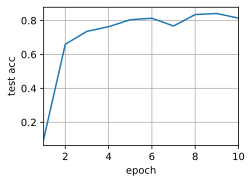

In [40]:
train(num_gpus=1, batch_size=256, lr=0.2)

In [ ]:
train(num_gpus=2, batch_size=256, lr=0.2)

小批量数据量更大时，学习率也需要稍微提高一些。

In [48]:
class Residual(nn.Module):  #@save
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [49]:
#@save
def resnet18(num_classes, in_channels=1):
    """稍加修改的ResNet-18模型"""
    def resnet_block(in_channels, out_channels, num_residuals,
                     first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(Residual(in_channels, out_channels,use_1x1conv=True, strides=2))
            else:
                blk.append(Residual(out_channels, out_channels))
        return nn.Sequential(*blk)

    # 该模型使用了更小的卷积核、步长和填充，而且删除了最大汇聚层
    net = nn.Sequential(
        nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU())
    net.add_module("resnet_block1", resnet_block(
        64, 64, 2, first_block=True))
    net.add_module("resnet_block2", resnet_block(64, 128, 2))
    net.add_module("resnet_block3", resnet_block(128, 256, 2))
    net.add_module("resnet_block4", resnet_block(256, 512, 2))
    net.add_module("global_avg_pool", nn.AdaptiveAvgPool2d((1,1)))
    net.add_module("fc", nn.Sequential(nn.Flatten(),
                                       nn.Linear(512, num_classes)))
    return net

In [50]:
net = resnet18(10)
# 获取GPU列表
devices = d2l.try_all_gpus()
# 我们将在训练代码实现中初始化网络

In [57]:
def train(net, num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    def init_weights(m):
        if type(m) in [nn.Linear, nn.Conv2d]:
            nn.init.normal_(m.weight, std=0.01)
    net.apply(init_weights)
    # 在多个GPU上设置模型
    net = nn.DataParallel(net, device_ids=devices)
    trainer = torch.optim.SGD(net.parameters(), lr)
    loss = nn.CrossEntropyLoss()
    timer, num_epochs = d2l.Timer(), 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    for epoch in range(num_epochs):
        print(epoch)
        net.train()
        timer.start()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(devices[0]), y.to(devices[0])
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        timer.stop()
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(net, test_iter),))
    print(f'测试精度：{animator.Y[0][-1]:.2f}，{timer.avg():.1f}秒/轮，'
          f'在{str(devices)}')

In [ ]:
train(net, num_gpus=1, batch_size=128, lr=0.1)

In [ ]:
train(net, num_gpus=2, batch_size=256, lr=0.1)